#### Week 1

Code to complete homework for Week 1 - Introduction of MLOps zoomcamp

Homework questions are [here](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2024/01-intro/homework.md)

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import root_mean_squared_error

In [88]:
df1 = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet", engine='pyarrow')
df2 = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet", engine='pyarrow')

#### Question 1

In [6]:
df1.shape

(3066766, 19)

#### Question 2

In [46]:
# Calculate duration
df1['duration'] =df1["tpep_dropoff_datetime"] -  df1["tpep_pickup_datetime"] 
df1["duration"] = df1["duration"].dt.total_seconds().div(60).astype(float)
df1["duration"].std()

42.59435124195458

#### Question 3

In [64]:
original_size = df1.shape[0]
df1 = df1[(df1["duration"] <= 60)
                 & (df1["duration"] >= 1)]
new_size = df1.shape[0]
frac_remain = new_size / original_size
print(f"{round(frac_remain*100, 0)}% of records remain after removing outliers.")

98.0% of records remain after removing outliers.


#### Question 4

In [65]:
cat_feat = ["PULocationID", "DOLocationID"]
df1[cat_feat] = df1[cat_feat].astype(str)
train_dicts = df1[cat_feat].to_dict(orient="records")

In [66]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [67]:
print(f"The feature matrix has {X_train.shape[1]} columns.")

The feature matrix has 515 columns.


#### Question 5

In [69]:
y_train = df1["duration"].values
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

In [78]:
y_pred

array([11.52719904, 10.89783953, 11.32587887, ..., 11.73754508,
       12.70515209, 11.54228187])

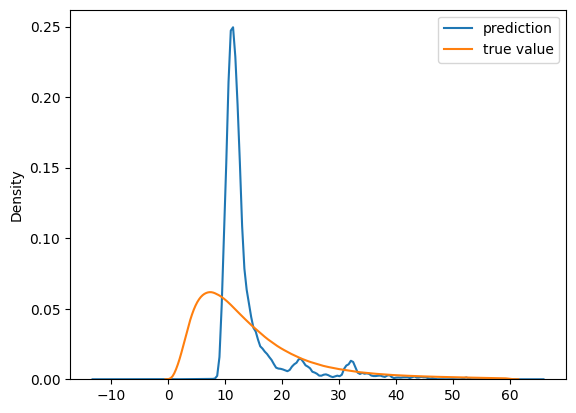

In [79]:
sns.kdeplot(y_pred, label = "prediction")
sns.kdeplot(y_train, label = "true value") 
plt.legend()
plt.show()

In [84]:
root_mean_squared_error(y_train, y_pred)

7.649261934850555

#### Question 6

In [90]:
# Prepare Feb dataset
df2['duration'] =df2["tpep_dropoff_datetime"] -  df2["tpep_pickup_datetime"] 
df2["duration"] = df2["duration"].dt.total_seconds().div(60).astype(float)

df2 = df2[(df2["duration"] <= 60)
                 & (df2["duration"] >= 1)]

df2[cat_feat] = df2[cat_feat].astype(str)
test_dicts = df2[cat_feat].to_dict(orient="records")
X_test = dv.fit_transform(test_dicts)

In [92]:
y_test = df2["duration"].values
lr.fit(X_test, y_test)
y_test_pred = lr.predict(X_test)
root_mean_squared_error(y_test, y_test_pred)


7.778948516082342